In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(DESeq2))
suppressMessages(library(pheatmap))
suppressMessages(library(ggrepel))
suppressMessages(library(pROC))
suppressMessages(library(caret))

suppressMessages(library(UpSetR))
suppressMessages(library("AnnotationDbi"))
suppressMessages(library("org.Hs.eg.db"))

source("../global_variables.R")
source("../theme_ggplot_prevail.R")

---
## Read in data

In [3]:
## Load in meta data and gene counts data
mdf = read.csv("../0_DATA/metadata_all.csv")
cnts = read.csv("../0_DATA/counts_all.csv",row.names=1)
cnts <- cnts[,mdf$Xsample_id]

## read in gene key
genekey = read.delim("../0_DATA/gencode.biotype.name.key.tsv")

## get all pairwise comparisons
all_groups = unique(mdf$inflam_cat)
print(all_groups)

## load DAA outputs
daa_rds <- readRDS("./output/pairwise_DAA.rds")

## get all comparisons
comparisons <- daa_rds %>% names

[1] "KD"                  "viral_infection"     "MISC"               
[4] "bacterial_infection" "other"               "Healthy"            


Warning message in gzfile(file, "rb"):
“cannot open compressed file './output/pairwise_DAA.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


---
## Consolidate outputs

### Functions

In [ ]:
get_sig <- function(C,rds,grp){

    ## get sig df & add comparison
    sig_df <- rds[[C]]$res_df %>% 
        dplyr::rename(gene_id = Row.names) %>% 
        mutate(comp = C) %>%
        dplyr::select(comp, gene_id, gene_name, gene_type, padj, log2FoldChange, baseMean, gene_name)

    ## change log2FC direction to match group of interest
    if(grp == unlist(strsplit(C,"<>"))[2]){
        sig_df <- sig_df %>% mutate(log2FoldChange = -1 * log2FoldChange)
    }

    return(sig_df)
}


get_overlapping_genes <- function(GRP,daa_rds,comparisons){

    ## get all relevant comparisons
    grp_comps <- comparisons[grepl(GRP,comparisons)]

    ## extract all significant genes and make data frame
    all_sig <- lapply(grp_comps, get_sig, daa_rds,GRP)
    all_sig_df <- do.call("rbind",all_sig) %>% 
        data.frame()

    ## sumarize to count occurrences
    sig_counts <- all_sig_df %>% 
        filter(padj < 0.05) %>% 
        group_by(gene_id,gene_name) %>% 
        dplyr::count() %>% dplyr::rename(occurrences = n) %>% 
        arrange(desc(occurrences))

    ## counts occurrences for plot
    num_occur <- sig_counts  %>% group_by(occurrences) %>% dplyr::count()

    return(list("all_sig_df" = all_sig_df, "sig_counts" = sig_counts, "num_occur" = num_occur))
}

### Loop over groups

In [ ]:
all_outputs <- list()

## iterate over all groups
for (GRP in all_groups){

    ## get overlapping data frames
    all_out <- get_overlapping_genes(GRP,daa_rds,comparisons)

    ## save to output
    all_outputs[[GRP]] = all_out

    ## make plot
    options(repr.plot.height = 4, repr.plot.width = 6)
    plt <- all_out[['num_occur']] %>% 
        ggplot(aes(x=occurrences, y = n))+
        geom_bar(stat="identity",width = 1, fill="forest green")+   #forest green   red  blue
        xlim(0,7)+
        theme_prevail()+
        labs(y="# genes", title = GRP)+
        theme(axis.text = element_text(size = 12),
            axis.title = element_text(size = 12),
            title = element_text(size = 12))

    # print(plt)
        }

all_outputs %>% saveRDS("./output/occur.rds")


## Load data frame for Healthy samples
all_outputs = readRDS("./output/occur.rds")


############
## SAVE 
############

### Save supplemeentary file
all_outputs[['Healthy']][['all_sig_df']] %>% 
    write.csv("./output/Supplementary-File2_pedInflam.Healthy-DESEQ.csv",row.names=F, quote=FALSE)

# ### save outputs
# comparisons <- daa_rds %>% names
# for (COMP in comparisons){
#     res = daa_rds[[COMP]]$res_df %>% dplyr::rename(gene_id = Row.names)
#     res %>% write.csv(paste0("./output/Supp_",gsub("<>","-",COMP),"_DESEQ.csv"),row.names = F,quote=FALSE)
#     }

### wrangle outputs

In [5]:
### Create healthy 
healthy_df <- all_outputs[['Healthy']][['all_sig_df']] %>% 
    mutate(grp = gsub("<>Healthy|Healthy<>","",comp)) %>%
    # filter(baseMean > 10) %>%
    # filter(abs(log2FoldChange) > 1) %>%
    filter(padj < 0.05)

output_list <- lapply(unique(healthy_df$grp), function(x) healthy_df %>% filter(grp == x) %>% pull(gene_id))
names(output_list) <- unique(healthy_df$grp)

In [7]:
all_outputs[['Healthy']][['all_sig_df']] %>% 
    filter(padj < 0.05) %>% 
    group_by(comp) %>% summarise(n = n()) %>% arrange(desc(n))

comp,n
<chr>,<int>
KD<>Healthy,6606
MISC<>Healthy,6535
bacterial_infection<>Healthy,6083
viral_infection<>Healthy,5743
other<>Healthy,2686


---
# Plot and Save

### Make upset plot

png 
  2

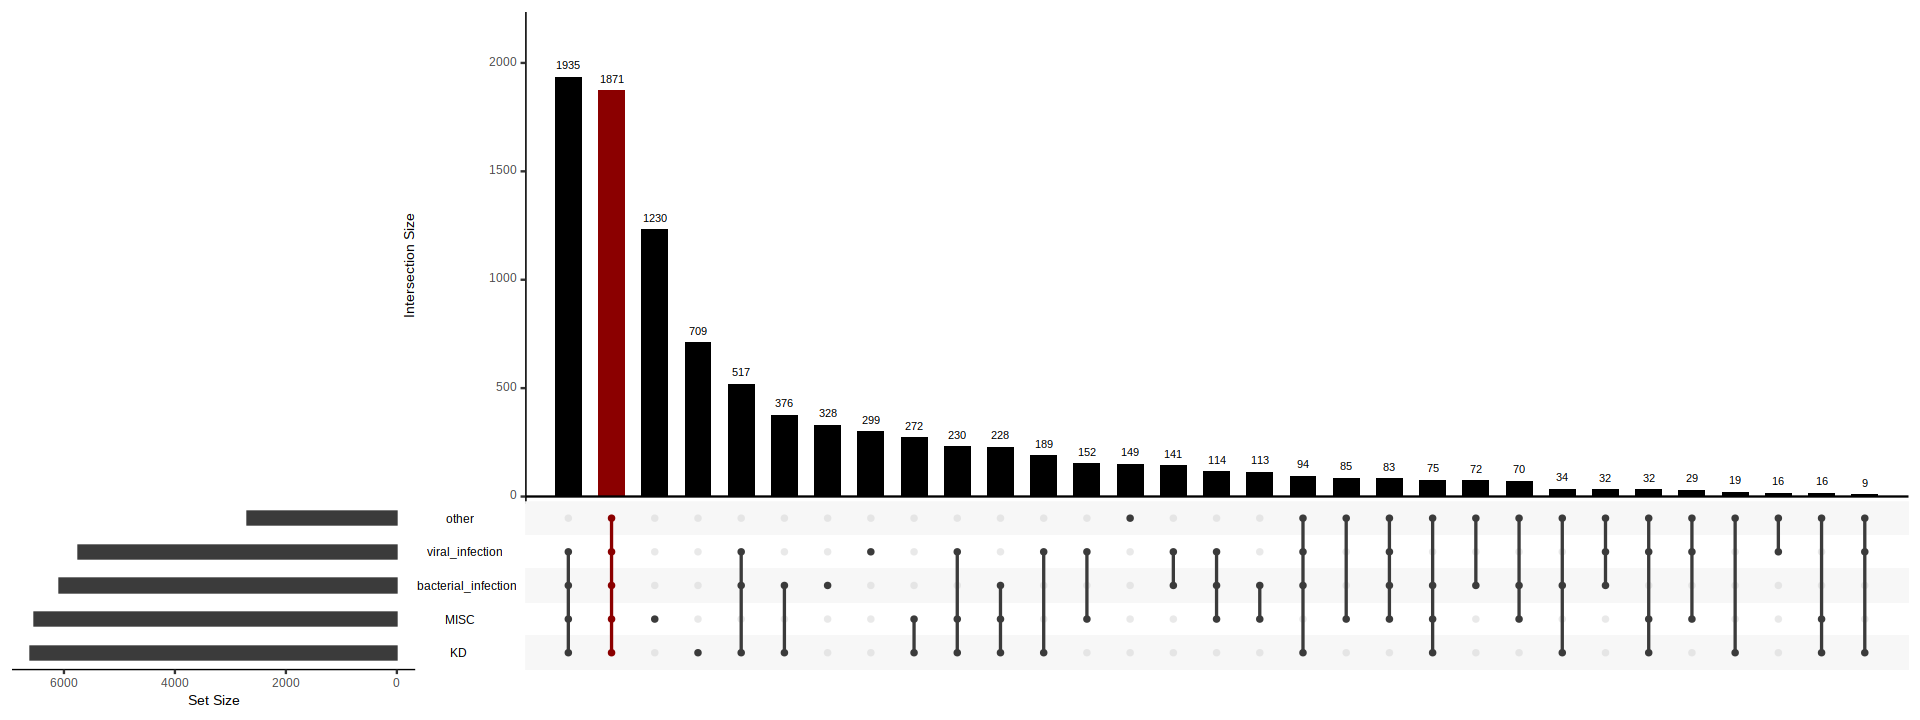

In [8]:
# plot(euler(output_list))

options(repr.plot.height = 6 ,repr.plot.width = 16)

upset_plt <- upset(fromList(output_list), 
    sets = unique(healthy_df$grp),
    # group.by = "sets", 
    order.by = "freq", 
    # order.by = c("degree", "freq"),
    point.size = 1.5,
    main.bar.color="black",

    queries = list(list(query = intersects, 
    params = list(unique(healthy_df$grp)), color = "red4", active = T)
    ))

WIDTH = 7
HEIGHT = 3

pdf(file=paste0("./plots/UPSET_healthy-all_plt.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
         colormodel = "srgb", pointsize=6, useDingbats = FALSE)

upset_plt

dev.off()

upset_plt

### Analyze overlapping genes

In [9]:
common_genes <- healthy_df %>%
    group_by(gene_name,gene_id,gene_type) %>% dplyr::count() %>%
    filter(n==5)

### Claims

The analysis also identified:
- immune related transcripts ILF2, IFI16, CD53, and CXCR2 elevated in each disease group, 
- homeostasis related transcripts CXCL5, , and, interestingly, 9 Y RNAs in the control group

In [16]:
# transcripts MPO, ELANE, CD53, and CXCR2 elevated in each disease group, homeostasis related transcripts CDK19, ANAPC5,

common_genes %>% filter(gene_name %in% c("ELANE","MPO","CD53","CXCR2"))
common_genes %>% filter(gene_name %in% c("CDK19","ANAPC5"))


gene_name,gene_id,gene_type,n
<chr>,<I<chr>>,<chr>,<int>
CD53,ENSG00000143119.14,protein_coding,5
CXCR2,ENSG00000180871.8,protein_coding,5
ELANE,ENSG00000197561.7,protein_coding,5
MPO,ENSG00000005381.8,protein_coding,5


gene_name,gene_id,gene_type,n
<chr>,<I<chr>>,<chr>,<int>
ANAPC5,ENSG00000089053.13,protein_coding,5
CDK19,ENSG00000155111.15,protein_coding,5


In [17]:
healthy_df %>% 
    filter(gene_id %in% common_genes$gene_id) %>% 
    group_by(gene_id,gene_name) %>% summarise(mean_padj = mean(padj), mean_FC = mean(log2FoldChange)) %>% 
    filter(grepl("MT-",gene_name)) %>% filter(mean_FC > 0) %>% nrow()

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


[1] 32

### IPA

In [20]:
## save ouput
healthy_df %>% 
    filter(gene_id %in% common_genes$gene_id) %>% 
    group_by(gene_id) %>% summarise(mean_padj = mean(padj), mean_FC = mean(log2FoldChange)) %>% 
    write.csv("./output/common_healthy-daa.ipa-table.csv",quote=FALSE, row.names=FALSE)


########################
### TMP FOR REBUTTAL ###
########################

# common_genes4 <- healthy_df %>% 
#     filter(!(gene_id %in% common_genes$gene_id)) %>%
#     filter(!grepl("other",comp)) %>%
#     group_by(gene_name,gene_id,gene_type) %>% dplyr::count() %>%
#     filter(n==4)

# common_genes4 %>% nrow()

# ## save ouput
# healthy_df %>% 
#     filter(gene_id %in% common_genes4$gene_id) %>% 
#     group_by(gene_id) %>% summarise(mean_padj = mean(padj), mean_FC = mean(log2FoldChange)) %>% 
#     write.csv("./output/common_healthy-daa.SUB4.ipa-table.csv",quote=FALSE, row.names=FALSE)

In [21]:
### IPA

## load output
df = read.delim("./output/common_healthy-daa.ipa-table.csv.txt",skip=2)
colnames(df) <- c("pathway","logpval","ratio","zscore","genes","X")

df <- df %>% 
    mutate(group=ifelse(zscore >0,"pos","neg")) %>% 
    mutate(group=ifelse(zscore == 0,"other",group)) %>% 
    filter(!is.na(group)) %>%
    arrange(desc(logpval))


df <- df %>% mutate(pathway = ifelse(grepl("Electron transport, ATP synthesis, and heat production by uncoupling proteins",pathway),
                                            "Electron transport/ATP synthesis/heat production",pathway))

df_top <- df %>% filter(group == "neg") %>% head(6)
df <- df_top %>%
    mutate(pathway = factor(pathway, levels=c(df_top$pathway %>% rev())))


WIDTH = 3
HEIGHT = 1.3

pdf(file=paste0("plots/UPSET_IPA.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)
        
    df %>% 
        # mutate(pathway = factor(pathway, levels = order)) %>%
        ggplot(aes(x=logpval, y=pathway, fill = group))+
        geom_bar(stat="identity")+
        labs(x="-log(p-value)")+
        theme_prevail()+
        theme(axis.title.x = element_text(size = 6))+
        theme(axis.title.y=element_blank())+
        scale_fill_manual(values = c("#FF5722","#3F51A1"))

dev.off()

png 
  2

### Histone Transcripts

In [20]:
cnts_vst<- DESeq2::varianceStabilizingTransformation(as.matrix(cnts))

In [21]:
common_genes <- healthy_df %>%
    group_by(gene_name,gene_id,gene_type) %>% dplyr::count() %>%
    filter(n==5)

histone_genes <- common_genes %>% filter(grepl("^H1|^H2|^H3|^H4",gene_name))
# histone_genes %>% head()

histone_ids <- histone_genes %>% pull(gene_id)
histone_ids %>% length()

[1] 42

In [22]:
mdf_hist_sum %>% write.csv("./output/supp_histoneCount.VST.csv",quote=FALSE,row.names=FALSE)

ERROR: Error in is.data.frame(x): object 'mdf_hist_sum' not found


`summarise()` has grouped output by 'sample_id', 'inflam_cat', 'inflam_cat2'.
You can override using the `.groups` argument.


sample_id,inflam_cat,inflam_cat2,HIST,sum_cnt
<chr>,<chr>,<fct>,<chr>,<dbl>
cfrna_kd_1,viral_infection,NA,H1,37.23443
cfrna_kd_1,viral_infection,NA,H2,128.55587
cfrna_kd_1,viral_infection,NA,H3,56.94647
cfrna_kd_1,viral_infection,NA,H4,48.90926
cfrna_kd_10,viral_infection,NA,H1,34.33245
cfrna_kd_10,viral_infection,NA,H2,117.03202


png 
  2

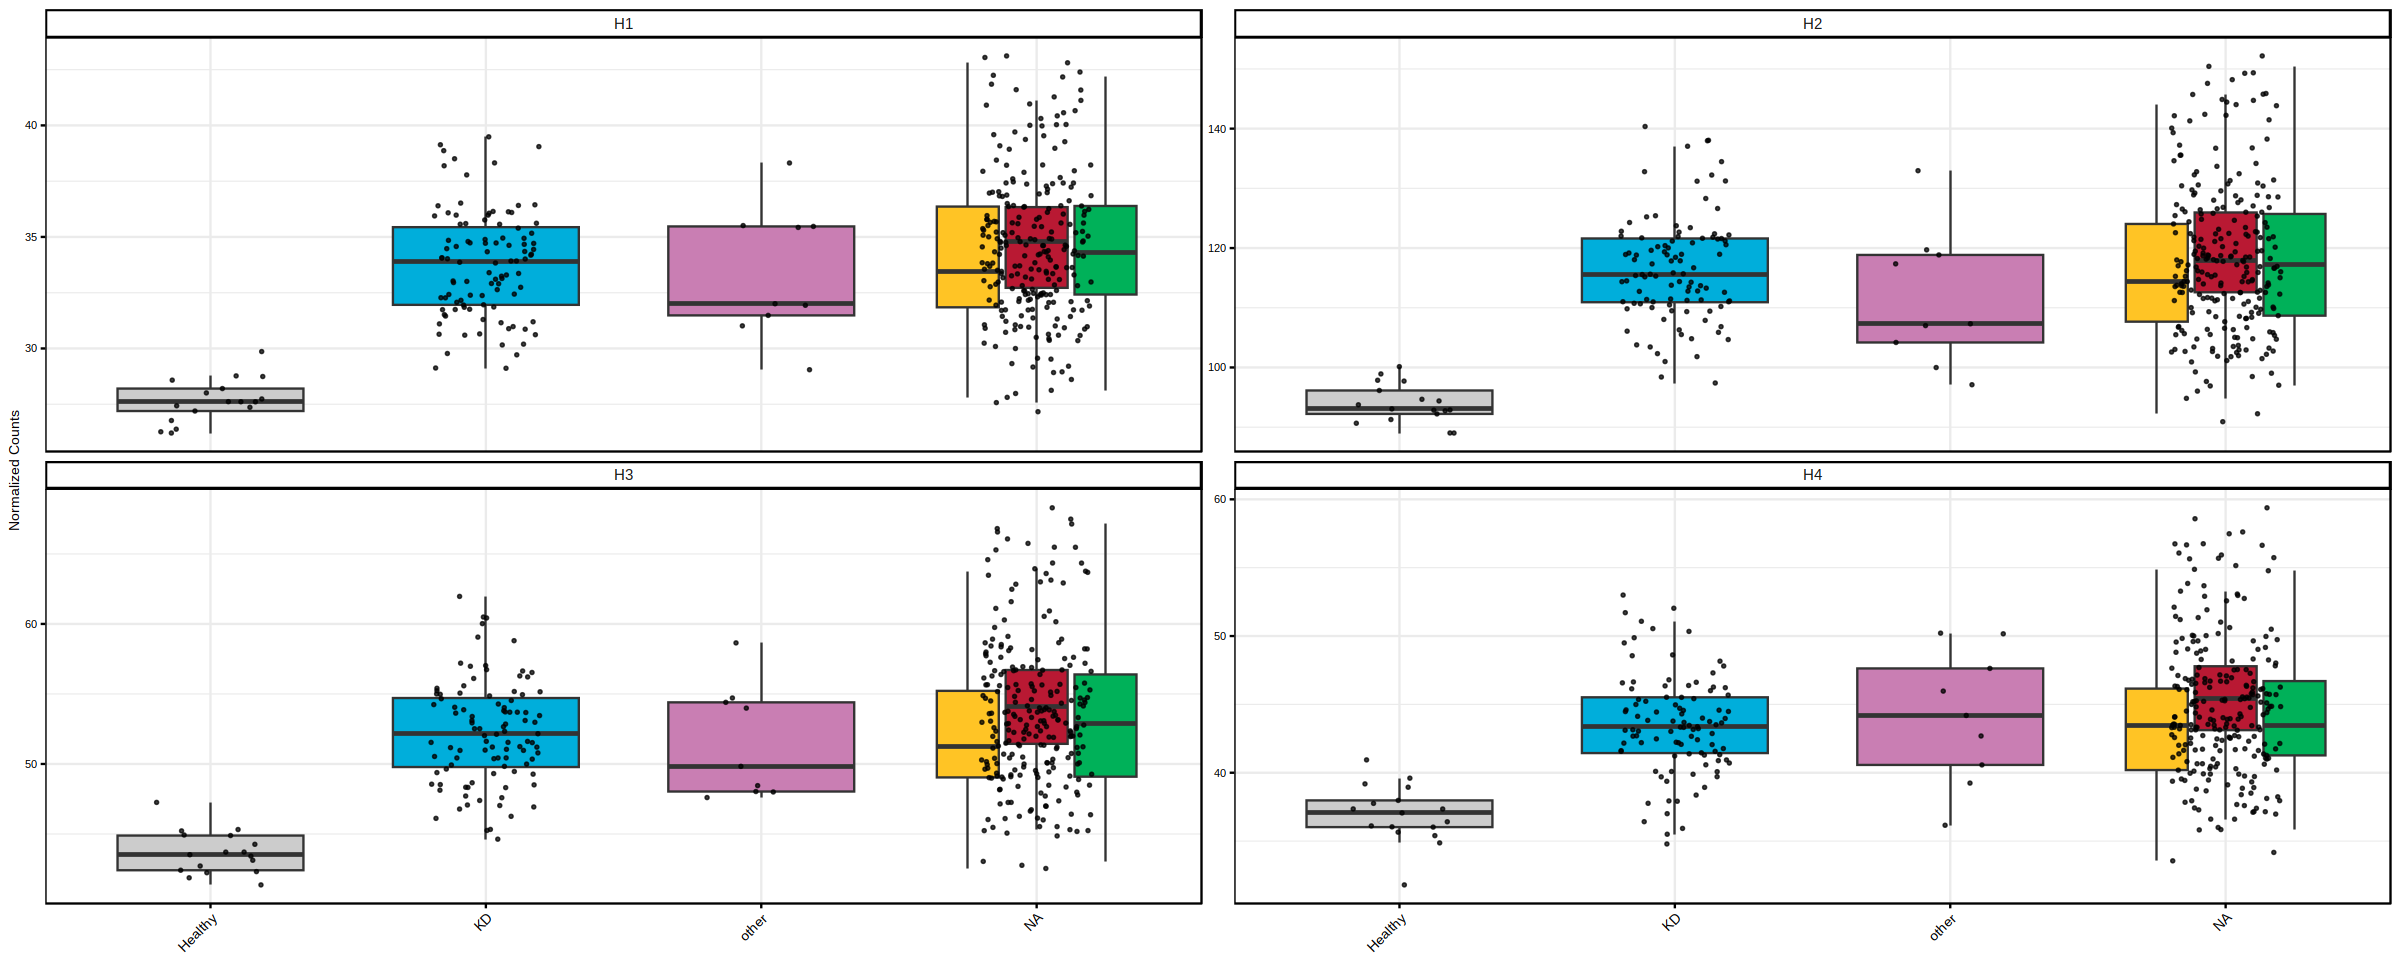

In [ ]:
common_genes <- healthy_df %>%
    group_by(gene_name,gene_id,gene_type) %>% dplyr::count() %>%
    filter(n==5)

histone_genes <- common_genes %>% filter(grepl("^H1|^H2|^H3|^H4",gene_name))
# histone_genes %>% head()

histone_ids <- histone_genes %>% pull(gene_id)

# HISTRNA
cnts_histone <- cnts_vst[histone_ids,] %>% t() %>% data.frame()

mdf_hist <- merge(mdf, cnts_histone, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(.,id.vars = colnames(mdf)) %>%
    dplyr::rename(gene_id = variable, counts_vst = value) %>%
    mutate(inflam_cat2 = gsub("_"," ",inflam_cat)) %>% mutate(inflam_cat2 = gsub("MISC","MIS-C",inflam_cat)) %>%
    mutate(inflam_cat2 = factor(inflam_cat2, levels = c("Healthy","MISC","KD","COVID19","viral infection","bacterial infection","other")))

mdf_hist <- merge(mdf_hist, histone_genes, by="gene_id") %>%
    mutate(HIST = substr(gene_name,1,2)) 
    
mdf_hist_sum <- mdf_hist %>%
    group_by(sample_id, inflam_cat,inflam_cat2, HIST) %>% summarise(sum_cnt = sum(counts_vst))
    
mdf_hist_sum %>% head

options(repr.plot.width = 20, repr.plot.height = 8)
histone_plot <- mdf_hist_sum %>% 
    ggplot(aes(x=inflam_cat2, y=sum_cnt, fill=inflam_cat))+
    geom_boxplot(outlier.shape=NA)+
    geom_jitter(width = 0.2, height = 0,size= 0.5, alpha = 0.75)+
    facet_wrap(~HIST, scales = "free_y")+
    theme_prevail()+
    labs(y = "Normalized Counts")+
    theme( strip.background = element_rect(color="black", fill="white", size=.75, linetype="solid"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
         axis.title.x = element_blank())+
    scale_fill_manual(values = INFLAMCAT_FILL_KEY)

WIDTH = 6
HEIGHT = 3

pdf(file=paste0("./plots/SUP-HLT_histone.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
         colormodel = "srgb", pointsize=6, useDingbats = FALSE)

histone_plot

dev.off()

histone_plot